In [1]:
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import numpy as np # linear algebra
from skimage.io import imread
from skimage.io import imsave
from imageio import imwrite
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage import img_as_ubyte
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
data_dir = '/mnt/disco/MaskRCNN/opencv_projects/SegmentObjectTrain/datasets/objects2019/'
train_image_origin_dir = os.path.join(data_dir, 'train_original')
train_image_dir = os.path.join(data_dir, 'train')
val_image_dir = os.path.join(data_dir, 'val')
backgrounds_dir = os.path.join(data_dir, 'backgrounds')
import gc; gc.enable() # memory is tight
from skimage.morphology import label

In [2]:
BATCH_SIZE = 25
EDGE_CROP = 2
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
#IMG_SCALING = (1, 1)
IMG_SCALING = None
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [3]:
def get_all_imgs():
    img_path = os.path.join(train_image_origin_dir,'annotations')
    images = glob.glob(os.path.join(img_path,'1*.*'))
    return [image.split('/')[-1] for image in images]

In [4]:
# print(get_all_imgs())
TRAIN_IMGS, TEST_IMGS = train_test_split(get_all_imgs())
print(len(TRAIN_IMGS))
print(len(TEST_IMGS))

4204
1402


In [5]:
import random
def cv2_brightness_augment(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    seed = random.uniform(0.8,1.2)
    v = (( v/255.0 ) * seed)*255.0
    hsv[:,:,2] = np.array(np.clip(v,0,255),dtype=np.uint8)
    rgb_final = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_final

In [6]:
def make_image_gen(img_file_list=TRAIN_IMGS, batch_size = BATCH_SIZE):
    all_batches = TRAIN_IMGS
    out_rgb = []
    out_mask = []
    out_classes = []
    img_path = os.path.join(train_image_origin_dir,'images')
    mask_path = os.path.join(train_image_origin_dir,'annotations')
    while True:
        #I Think tha this is slow, comment and generate the random shuffle in main init call
        #np.random.shuffle(all_batches)
        for c_img_id in all_batches:
            c_img_name_split = c_img_id.split('_')
            c_img_class = c_img_id.split('-')[1]
            c_img_name = c_img_id.split('-')[0] + "."  + c_img_id.split('-')[2].split('.')[1]
            c_img = imread(os.path.join(img_path,c_img_name))
            c_img = cv2_brightness_augment(c_img)
            c_mask = imread(os.path.join(mask_path,c_img_id))
            if IMG_SCALING is not None:
                c_img = cv2.resize(c_img,(256,256),interpolation = cv2.INTER_AREA)
                c_mask = cv2.resize(c_mask,(256,256),interpolation = cv2.INTER_AREA)
            c_mask = np.reshape(c_mask,(c_mask.shape[0],c_mask.shape[1],-1))
            c_mask = c_mask > 0
            out_rgb += [c_img]
            out_mask += [c_mask]
            out_classes += [c_img_class]
            if len(out_mask)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0), out_classes
                out_rgb, out_mask, out_classes=[], [], []

In [7]:
#np.random.shuffle(TRAIN_IMGS)
train_gen = make_image_gen()
train_x, train_y, img_class = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())
print(img_class)

('x', (25, 480, 640, 3), 0.0, 1.0)
('y', (25, 480, 640, 1), False, True)
['potato_chips', 'papikra', 'grape_juice', 'chocolate_drink', 'orange_juice', 'orange_juice', 'orange_juice', 'potato_chips', 'tray', 'orange_juice', 'grape_juice', 'pringles', 'grape_juice', 'orange_juice', 'tray', 'coke', 'grape_juice', 'papikra', 'grape_juice', 'papikra', 'tray', 'cereal', 'coke', 'orange_juice', 'grape_juice']


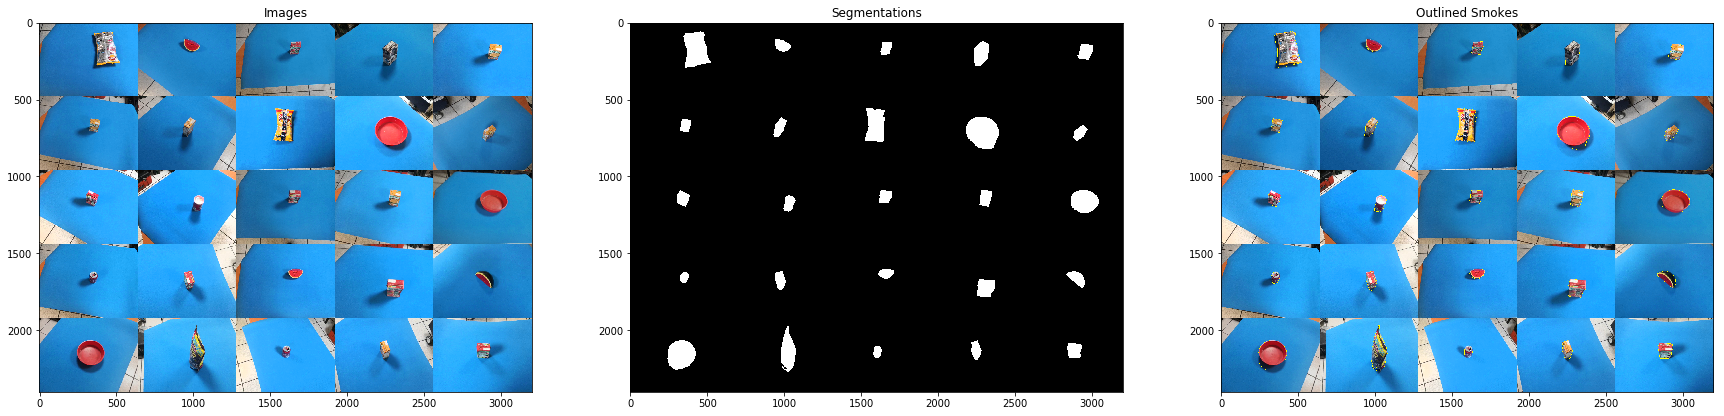

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg, cmap='gray')
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Smokes')
fig.savefig('overview.png')

In [9]:
#valid_x, valid_y, valid_class = next(make_image_gen(TEST_IMGS,len(TEST_IMGS)))
#print(valid_x.shape, valid_y.shape, valid_class)
val_gen = make_image_gen(TEST_IMGS, BATCH_SIZE)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 30, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.7, 1.75],  
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'constant',
                  data_format = 'channels_last',
                  validation_split=0.2)
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y, in_class in in_gen:
        seed = np.random.choice(range(9999))
        #print seed
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=False)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=False)

        yield next(g_x)/255.0, next(g_y), in_class

Using TensorFlow backend.


In [11]:
images_backgrounds = glob.glob(os.path.join(backgrounds_dir,'*.*'))
background_images = []
for image_background in images_backgrounds:
    background_image = imread(image_background)
    background_images += [background_image]
#print (random.randint(0,len(images_backgrounds)))
#print (len(background_images))

15
15


In [12]:
cur_gen = create_aug_gen(train_gen)
count = 0

t_x = []
t_y = []
in_class = []
initCount = 2000000

img_path = os.path.join(train_image_dir,'images')
mask_path = os.path.join(train_image_dir,'annotations')

while True:
    try:
        t_x, t_y, in_classes = next(cur_gen)
        #print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
        #print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
        #print(in_classes)
        for index in range(len(t_x)):
            image = img_as_ubyte(t_x[index][...,::-1])
            #image = img_as_ubyte(t_x[index])
            mask = img_as_ubyte(t_y[:, :, :, 0][index])               
            mask_inv = cv2.bitwise_not(mask)
            
            img1_bg = background_images[random.randint(0,len(images_backgrounds) - 1)][...,::-1]
            img1_bg = cv2.resize(img1_bg, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_AREA)
            #img1_bg = cv2.bitwise_and(img1_bg, img1_bg, mask = mask_inv)
            img1_bg = cv2.bitwise_or(img1_bg, img1_bg, mask = mask_inv)
            #img1_bg = background_images[random.randint(0,len(images_backgrounds) - 1)][...,::-1]
            
            img1_fg = cv2.bitwise_or(image, image, mask = mask)
            
            scene_image = cv2.add(img1_fg, img1_bg)
            
            
            #scene_image = np.concatenate((img1_bg, img1_fg), axis=1)
            #imwrite(os.path.join(img_path, str(initCount) + ".png"), scene_image)
            cv2.imwrite(os.path.join(img_path, str(initCount) + ".png"), scene_image)
            imwrite(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),t_y[:, :, :, 0][index])
            
            #img2_obj = cv2.bitwise_and(image, mask = mask_inv)
            #imwrite(os.path.join(img_path, str(initCount) + ".png"), img1_bg)
            #imsave(os.path.join(img_path, str(initCount) + ".png"), t_x[index])
            #imsave(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),t_y[:, :, :, 0][index])
            #imwrite(os.path.join(img_path, str(initCount) + ".png"), t_x[index])
            #imwrite(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),t_y[:, :, :, 0][index])
            initCount += 1
            #imsave("",t_x[0])
        gc.collect()
    except StopIteration:
        break
#t_x, t_y = next(cur_gen)
#print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
#print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#print(len(t_x))
#print(len(t_y))
#print(len(t_y[:, :, :, 0][0]))
#t_x = t_x[:9]
#t_y = t_y[:9]
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
#ax1.imshow(montage_rgb(t_x), cmap='gray')
#ax1.set_title('images')
#ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
#ax2.set_title('smoke')
#fig.savefig('augmentations.png')
#cur_gen = create_aug_gen(train_gen)
#t_x, t_y = next(cur_gen)
#print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
#print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#print(len(t_x))
#print(len(t_y))
#print(len(t_y[:, :, :, 0][0]))
#t_x = t_x[:9]
#t_y = t_y[:9]
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
#ax1.imshow(montage_rgb(t_x), cmap='gray')
#ax1.set_title('images2')
#ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
#ax2.set_title('smoke2')
#fig.savefig('augmentations.png')

4313


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
No handlers could be found for logger "imageio"


494
3526
5032
6689
4447
2288
1051
2450
2823
2808
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742


KeyboardInterrupt: 

In [ ]:
gc.collect()

In [13]:
cur_gen = create_aug_gen(val_gen)
count = 0

v_x = []
v_y = []
in_class = []

initCount = 2000000

img_path = os.path.join(val_image_dir,'images')
mask_path = os.path.join(val_image_dir,'annotations')

while True:
    try:
        v_x, v_y, in_classes = next(cur_gen)
        for index in range(len(v_x)):
            image = img_as_ubyte(v_x[index][...,::-1])
            #image = img_as_ubyte(t_x[index])
            mask = img_as_ubyte(v_y[:, :, :, 0][index])               
            mask_inv = cv2.bitwise_not(mask)
            img1_bg = background_images[random.randint(0,len(images_backgrounds) - 1)][...,::-1]
            img1_bg = cv2.resize(img1_bg, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_AREA)
            #img1_bg = cv2.bitwise_and(img1_bg, img1_bg, mask = mask_inv)
            img1_bg = cv2.bitwise_or(img1_bg, img1_bg, mask = mask_inv)
            #img1_bg = background_images[random.randint(0,len(images_backgrounds) - 1)][...,::-1]
            img1_fg = cv2.bitwise_or(image, image, mask = mask)
            scene_image = cv2.add(img1_fg, img1_bg)
            cv2.imwrite(os.path.join(img_path, str(initCount) + ".png"), scene_image)
            imwrite(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),v_y[:, :, :, 0][index])
            initCount += 1
        gc.collect()
    except StopIteration:
        break

9096
2175
3194
2796
6185
969
8332
4555
7603
725
721
3800
188
3653
5382
4542
9811
8879
6016
508
6737
7387
3297
9094
3007
7969
623
903
6130
7694
7361
5148
9138
3383
3298
2683
6744
6963
9391
49
9306
9522
9612
238
739
4038
5305
7379
3938
5704
119
8912
1035
5588
1490
8473
5863
724
7731
8256
1002
6218
5839
270
1335
490
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081
5919
2791
7569
3528
7780
4742
6476
658
8062
7081


KeyboardInterrupt: 